# Bayesian Linear Regression: 
Computational bayes final project.  
Nathan Yee  
Uma Desai  

First example to gain understanding is taken from Cypress Frankenfeld.
http://allendowney.blogspot.com/2015/04/two-hour-marathon-by-2041-probably.html

In [11]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint, EvalNormalPdf
import thinkplot
import pandas as pd
import matplotlib.pyplot as plt

From: http://lib.stat.cmu.edu/DASL/Datafiles/Ageandheight.html
> The height of a child is not stable but increases over time. Since the pattern of growth varies from child to child, one way to understand the general growth pattern is by using the average of several children's heights, as presented in this data set. The scatterplot of height versus age is almost a straight line, showing a linear growth pattern. The straightforward relationship between height and age provides a simple illustration of linear relationships, correlation, and simple regression. 

>Description: Mean heights of a group of children in Kalama, an Egyptian village that is the site of a study of nutrition in developing countries. The data were obtained by measuring the heights of all 161 children in the village each month over several years. 

>Age: Age in months

>Height: Mean height in centimeters for children at this age 


Let's start by loading our data into a Pandas dataframe to see what we're working with.

In [12]:
df = pd.read_csv('ageVsHeight.csv', skiprows=0, delimiter='\t')
df

,age,height
0,18,76.1
1,19,77.0
2,20,78.1
3,21,78.2
4,22,78.8
5,23,79.7
6,24,79.9
7,25,81.1
8,26,81.2
9,27,81.8


Next, let's create vectors of our ages and heights.

In [13]:
ages = np.array(df['age'])
heights = np.array(df['height'])

Now let's visualize our data to make sure that linear regression is appropriate for predicting its distributions.

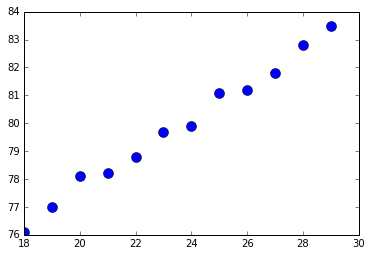

In [14]:
plt.plot(ages, heights, 'o', label='Original data', markersize=10)

Our data looks pretty linear. We can now calculate the slope and intercept of the line of least squares. We abstract numpy's least squares function using a function of our own.

In [15]:
def leastSquares(x, y):
    """
    leastSquares takes in two arrays of values. Then it returns the slope and intercept
    of the least squares of the two.
    
    Args:
        x (numpy array): numpy array of values.
        y (numpy array): numpy array of values.
        
    Returns:
        slope, intercept (tuple): returns a tuple of floats.
    """
    A = np.vstack([x, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A, y)[0]
    return slope, intercept

To use our leastSquares function, we input our age and height vectors as our x and y arguments. Next, let's call leastSquares to get the slope and intercept, and use the slope and intercept to calculate the size of our alpha (intercept) and beta (slope) ranges.

In [16]:
slope, intercept = leastSquares(ages, heights)
print(slope, intercept)
alpha_range = .03 * intercept
beta_range = .05 * slope

0.634965034965 64.9283216783


Now we can visualize the slope and intercept on the same plot as the data to make sure it is working correctly.

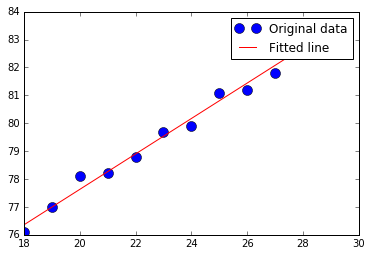

In [17]:
plt.plot(ages, heights, 'o', label='Original data', markersize=10)
plt.plot(ages, slope*ages + intercept, 'r', label='Fitted line')
plt.legend()
plt.show()

Looks great! Based on the plot above, we are confident that bayesian linear regression will give us reasonable distributions for predicting future values. Now we need to create our hypotheses. Each hypothesis will consist of a range of intercepts (alphas), slopes (betas) and sigmas.

In [19]:
alphas = np.linspace(intercept - alpha_range, intercept + alpha_range, 20)
betas = np.linspace(slope - beta_range, slope + beta_range, 20)
sigmas = np.linspace(2, 4, 15)

In [20]:
hypos = ((alpha, beta, sigma) for alpha in alphas 
         for beta in betas for sigma in sigmas)

In [25]:
data = [(age, height) for age in ages for height in heights]

Next make a least squares class that inherits from Suite and Joint where likelihood is calculated based on error from data. The likelihood function will depend on the data and normal distributions for each hypothesis.

In [22]:
class leastSquaresHypos(Suite, Joint):
    def Likelihood(self, data, hypo):
        """
        Likelihood calculates the probability of a particular line (hypo)
        based on data (ages Vs height) of our original dataset. This is
        done with a normal pmf as each hypo also contains a sigma.
        
        Args:
            data (tuple): tuple that contains ages (float), heights (float)
            hypo (tuple): intercept (float), slope (float), sigma (float)
            
        Returns:
            P(data|hypo)
        """
        intercept, slope, sigma = hypo
        total_likelihood = 1
        for age, measured_height in data:
            hypothesized_height = slope * age + intercept
            error = measured_height - hypothesized_height
            total_likelihood *= EvalNormalPdf(error, mu=0, sigma=sigma)
        return total_likelihood
        

Now instantiate a LeastSquaresHypos suite with our hypos.

In [23]:
LeastSquaresHypos = leastSquaresHypos(hypos)

And update the suite with our data.

In [27]:
for item in data:
    LeastSquaresHypos.Update([item])

In [ ]:
LeastSquaresHypos[LeastSquaresHypos.MaximumLikelihood()]

We can now plot marginal distributions to visualize the probability distribution for each of our hypotheses for intercept, slope, and sigma values. Our hypotheses were carefully picked based on ranges that we found worked well, which is why all the intercepts, slopes, and sigmas that are important to this dataset are included in our hypotheses.

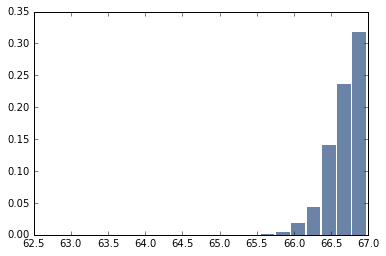

In [46]:
marginal_intercepts = LeastSquaresHypos.Marginal(0)
thinkplot.hist(marginal_intercepts)

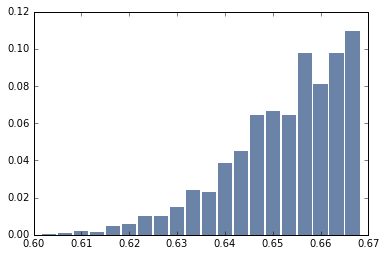

In [30]:
marginal_slopes = LeastSquaresHypos.Marginal(1)
thinkplot.hist(marginal_slopes)

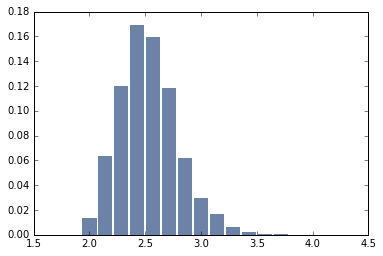

In [31]:
marginal_sigmas = LeastSquaresHypos.Marginal(2)
thinkplot.hist(marginal_sigmas)

Next, we want to sample random data from our hypotheses. To do this, we will make two functions, getHeights and getRandomData. getRandomData calls getHeights to obtain random height values.

In [41]:
def getHeights(hypo_samples, random_months):
    """
    getHeights takes in random hypos and random months and returns the corresponding
    random height
    
    """
    random_heights = np.zeros(len(random_months))
    for i in range(len(random_heights)):
        intercept = hypo_samples[i][0]
        slope = hypo_samples[i][1]
        sigma = hypo_samples[i][2]
        month = random_months[i]
        random_heights[i] = np.random.normal((slope * month + intercept), sigma, 1)
    return random_heights

def getRandomData(start_month, end_month, n, LeastSquaresHypos):
    """
    start_month (int): Starting x range of our data
    end_month (int): Ending x range of our data
    n (int): Number of samples
    LeastSquaresHypos (Suite): Contains the hypos we want to sample
    """
    random_hypos = LeastSquaresHypos.Sample(n)
    random_months = np.random.uniform(start_month, end_month, n)
    random_heights = getHeights(random_hypos, random_months)
    return random_months, random_heights

Now we take 10000 random samples of pairs of months and heights. Here we want at least 10000 items so that we can get very smooth sampling.

In [38]:
num_samples = 10000
random_months, random_heights = getRandomData(18, 40, num_samples, LeastSquaresHypos)

Next, we want to get the intensity of the data at locations. We do that by adding the randomly sampled values to buckets. This gives us intensity values for a grid of pixels in our sample range.

In [44]:
num_buckets = 70   #num_buckets^2 is actual number

# create horizontal and vertical linearly spaced ranges as buckets.
hori_range, hori_step = np.linspace(18, 40 , num_buckets, retstep=True)
vert_range, vert_step = np.linspace(65, 100, num_buckets, retstep=True)

hori_step = hori_step / 2
vert_step = vert_step / 2

# store each bucket as a tuple in a the buckets dictionary.
buckets = dict()
keys = [(hori, vert) for hori in hori_range for vert in vert_range]

# set each bucket as empty
for key in keys:
    buckets[key] = 0
    
# loop through the randomly sampled data
for month, height in zip(random_months, random_heights):
    # check each bucket and see if randomly sampled data 
    for key in buckets:
        if month > key[0] - hori_step and month < key[0] + hori_step:
            if height > key[1] - vert_step and height < key[1] + vert_step:
                buckets[key] += 1
                break # can only fit in a single bucket

In [20]:
pcolor_months = []
pcolor_heights = []
pcolor_intensities = []
for key in buckets:
    pcolor_months.append(key[0])
    pcolor_heights.append(key[1])
    pcolor_intensities.append(buckets[key])   
    
print(len(pcolor_months), len(pcolor_heights), len(pcolor_intensities))

4900 4900 4900


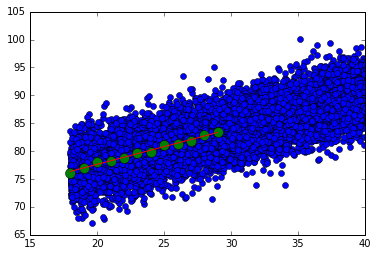

In [21]:
plt.plot(random_months, random_heights, 'o', label='Random Sampling')
plt.plot(ages, heights, 'o', label='Original data', markersize=10)
plt.plot(ages, slope*ages + intercept, 'r', label='Fitted line')
# plt.legend()
plt.show()

Since density plotting is much simpler in Mathematica, we have written these funcitons to export all our data to csv files and plot them in Mathematica.

In [23]:
def append_to_file(path, data):
    """
    append_to_file appends a line of data to specified file.  Then adds new line
    
    Args:
        path (string): the file path
    
    Return:
        VOID
    """
    with open(path, 'a') as file:
        file.write(data + '\n')
        
def delete_file_contents(path):
    """
    delete_file_contents deletes the contents of a file
    
    Args:
        path: (string): the file path
        
    Return:
        VOID
    """
    with open(path, 'w'):
        pass

def intensityCSV(x, y, z):
    file_name = 'intensityData.csv'
    delete_file_contents(file_name)

    for xi, yi, zi in zip(x, y, z):
        append_to_file(file_name, "{}, {}, {}".format(xi, yi, zi))
        
def monthHeightCSV(ages, heights):
    file_name = 'monthsHeights.csv'
    delete_file_contents(file_name)
    
    for month, height in zip(ages, heights):
        append_to_file(file_name, "{}, {}".format(month, height))
        
def fittedLineCSV(ages, slope, intercept):
    file_name = 'fittedLineCSV.csv'
    delete_file_contents(file_name)
    for age in ages:
        append_to_file(file_name, "{}, {}".format(age, slope*age + intercept))
        
def makeCSVData(pcolor_months, pcolor_heights, pcolor_intensities, ages, heights, slope, intercept):
    intensityCSV(pcolor_months, pcolor_heights, pcolor_intensities)
    monthHeightCSV(ages, heights)
    fittedLineCSV(ages, slope, intercept)

In [43]:
makeCSVData(pcolor_months, pcolor_heights, pcolor_intensities, ages, heights, slope, intercept)